In [1]:
import tensorflow as tf 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow.keras.layers as layers 

In [2]:
data=tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test)=data.load_data()



In [22]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1,activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()
latent_dim = 2

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256,1,1),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64,4,1,padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="tanh"),
    ],
    name="generator",
)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
global_max_pooling2d_4 (Glob (None, 128)             

In [26]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam(learning_rate=0.00003)
g_optimizer = keras.optimizers.Adam(learning_rate=0.00003)

# Instantiate a loss function.



@tf.function
def train_step(real_images):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Decode them to fake images
    generated_images = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)

    # Train the discriminator
    
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
  
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images

In [27]:
import os

# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0*2-1 
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

epochs = 200  # In practice you need at least 20 epochs to generate nice digits.
save_dir = "./"

for epoch in range(epochs):
    print("\nStart epoch", epoch)

    for step, real_images in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(real_images)

        # Logging.
        if step % 200 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            # Save one generated image
            img = tf.keras.preprocessing.image.array_to_img(
                (generated_images[0]+1) * 255.0/2, scale=False
            )
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))

        # To limit execution time we stop after 10 steps.
        # Remove the lines below to actually train the model!
        # if step > 10:
        #     break


Start epoch 0
discriminator loss at step 0: 0.37
adversarial loss at step 0: 3.01
discriminator loss at step 200: 0.40
adversarial loss at step 200: 1.55
discriminator loss at step 400: 0.24
adversarial loss at step 400: 1.94
discriminator loss at step 600: 0.43
adversarial loss at step 600: 1.86
discriminator loss at step 800: 0.28
adversarial loss at step 800: 1.91
discriminator loss at step 1000: 0.27
adversarial loss at step 1000: 1.86

Start epoch 1
discriminator loss at step 0: 0.35
adversarial loss at step 0: 2.60
discriminator loss at step 200: 0.35
adversarial loss at step 200: 1.77
discriminator loss at step 400: 0.30
adversarial loss at step 400: 1.80
discriminator loss at step 600: 0.38
adversarial loss at step 600: 2.14
discriminator loss at step 800: 0.36
adversarial loss at step 800: 1.93
discriminator loss at step 1000: 0.32
adversarial loss at step 1000: 2.00

Start epoch 2
discriminator loss at step 0: 0.31
adversarial loss at step 0: 1.89
discriminator loss at step 

KeyboardInterrupt: 

In [8]:

generator.save("./generator")
# os.rmdir('./discriminator')
os.mkdir('./discriminator')
discriminator.save('./discriminator')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./generator\assets
INFO:tensorflow:Assets written to: ./discriminator\assets


In [9]:
generator=tf.keras.models.load_model('./generator')


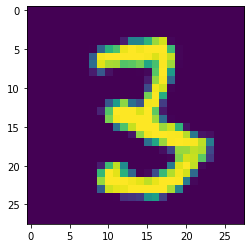

In [54]:
iamge2=generator(tf.random.normal(shape=(1, latent_dim)))
plt.imshow(iamge2[0])

In [18]:
import numpy 
class Solution(object):
    def heightChecker(self, heights):
        """
        :type heights: List[int]
        :rtype: int
        """
        out=0
        num=0
        a=numpy.zeros((101,1))
        for i in heights:
            a[i]+=1
        for i in range(1,101):
            if a[i]>0:
                for j in range(int(a[i])):
                    # print(num+j)
                    if heights[num+j]!=i:
                        out +=1
                num+=int(a[i])
        return out 
        

In [19]:
Solution().heightChecker([1,1,4,2,1,3])

3